# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die **Zusatzqualifikation KI und Maschinelles Lernen.** 

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

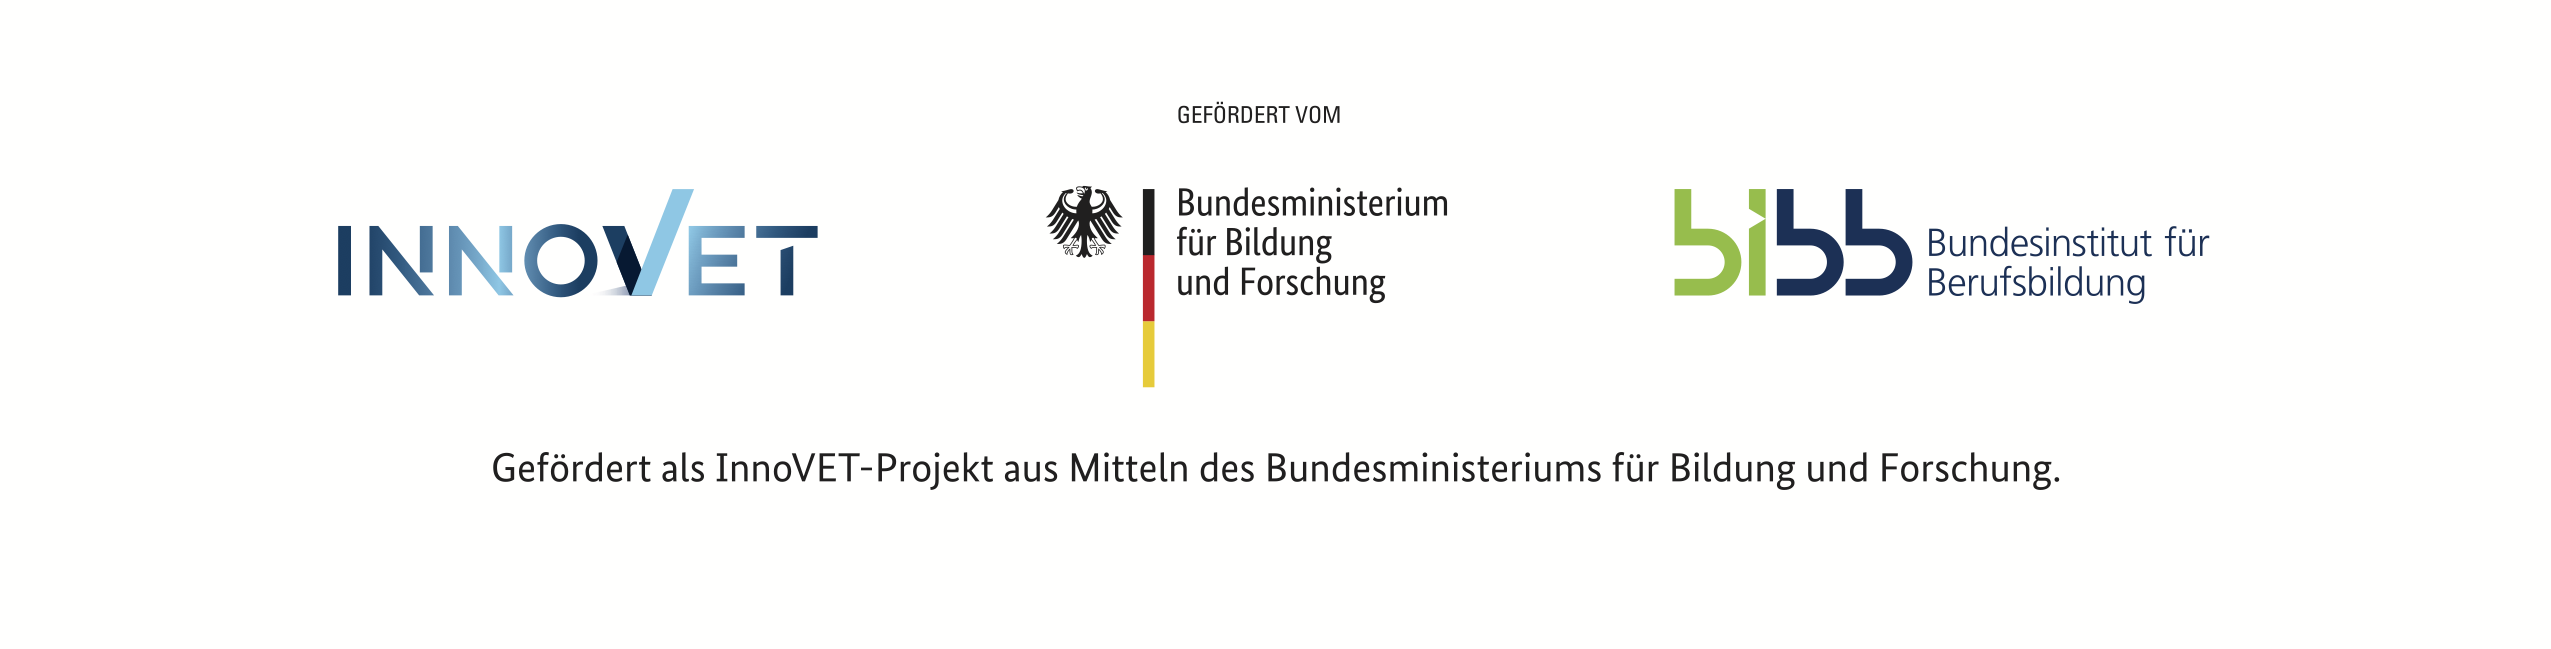

# Lizenzhinweis

Dieses Notebook "Klassifikationsbäume trainieren: Klassifikationsbäume, Teil 2 (Lösung)" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt. 

Das Werk, mit Ausnahme der oben abgebildenten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Klassifikationsbäume erstellen

Wenn man Klassifikatonsbäume erstellt, oder "trainiert", ist das Ziel, einen Baum zu erstellen, bei dem die an den Blättern vorkommenden Klassen möglichst homogen sind (also lauter gleiche Klassen). Umgangssprachlich gesprochen, sucht man also einen Baum, dessen Blätter von der Verteilung der Klassen her möglichst "sauber" oder "ordentlich" sind. 

Das Erstellen des Baums erfolgt Schritt für Schritt, beginnend mit allen Daten und einem obersten Knoten. An allen Knoten außer an den sogenannten Blättern wird verzweigt, d.h., es wird ein Kriterium gesucht, gemäß dessen die Daten auf zwei kleinere Teilmengen aufgeteilt werden. Anschließend erstellt man für die Teilmengen je einen Klassifikationsbaum. Diese beiden Bäume werden links und rechts unter dem aktuellen Knoten eingefügt. Wenn die zu einem Knoten gehörende Menge "sauber" zu einer bestimmten Klasse gehört, wird nicht weiter verzweigt: es handelt sich also um ein Blatt. 

Da das ultimative Ziel ist, an den Blättern möglichst homogene Klassen zu haben, versucht man, die Homogenität schon beim Bauen zu optimieren, d.h. man wählt für die Aufteilung in Unterbäume immer das Kriterium, das die "ordentlichsten" neuen Unterknoten ergibt. 

Dieses Notebook demonstriert, wie nach dem besten Kriterium gesucht wird. 

## Daten vorbereiten

In [ ]:
# für DataFrames
import pandas

Wir laden die Daten, behalten aber nur jede 11. Zeile aus den Eisdaten, um die Menge von Daten überschaubar zu halten: `.loc` wählt, [wie im Notebook "Daten als Tabellen darstellen" schon gesehen](https://antje-schweitzer.github.io/Jupyter_Notebooks_KI_und_Maschinelles_Lernen/C1.Daten.als.Tabellen.darstellen.ipynb), Zeilen aus: Die Zeilen werden in der eckigen Klammer genannt. (Wahlweise könnten anschließend nach einem Komma noch Spalten ausgewählt werden).

Hier bedeutet das `::11` in der eckigen Klammer: "jedes 11. Element". Im Ausdruck `loc[::11]` also: "jede 11. Zeile". 

In [ ]:
# Wetterdaten laden
wetter_url = 'https://github.com/antje-schweitzer/wetterdaten/raw/main/wetterdaten.csv'
wetter = pandas.read_csv(wetter_url)

# Eisdaten laden
eisdaten = pandas.read_csv('https://github.com/antje-schweitzer/eisverkauf2018/raw/main/eisverkauf.2018.csv')
# nur jede 11. Zeile behalten
eisdaten = eisdaten.loc[::11]

# Wetter- und Eisdaten zusammenführen
daten = pandas.merge(wetter,eisdaten,left_on='Datum',right_on='Datum')



Wir formen die Daten noch etwas um: zunächst runden wir die kontinuierlichen Werte zur Verbesserung der Lesbarkeit auf ganze Zahlen. 
Außerdem ergänzen wir eine Spalte für 'Wochenende' sowie eine Spalte mit der gewünschten Klasse 'Zustand'. 

Beim Feature 'Wochenende' ist es wichtig, dass wir als Werte 0 und 1 verwenden, und nicht etwa 'ja' und 'nein', denn der `DecisionTreeClassifier()` in `sklearn` kann nicht mit kategorialen unabhängigen Variablen umgehen. D.h. in den Spalten, die für die Vorhersage genutzt werden sollen, dürfen nur Zahlenwerte vorkommen. (Anders in der Spalte, die vorhergesagt werden soll, hier handelt es sich bei Klassifikationsbäumen natürlich immer um kategoriale Variablen: ein Klassifikationsbaum sagt ja Klassen vorher, und nicht kontinuierliche Werte.)

In unserem Fall ist die Lösung für das Feature Wochenende mit 0 für 'nein' und 1 für 'ja' naheliegend. Im Fall von kategorialen Variablen mit mehr als zwei möglichen Werten (wie z.B. den Wochentagen 'Montag', 'Dienstag', usw.) müsste man hier Dummy-Variablen einführen, wie bei der Linearen Regression. Falls Sie unschlüssig sind, was das ist, sehen Sie sich das Video oder das [Notebook zur Multiplen Linearen Regression](https://antje-schweitzer.github.io/Jupyter_Notebooks_KI_und_Maschinelles_Lernen/D3-2.Multiple.Lineare.Regression.ipynb) an, dort wird es ausführlicher erklärt. Hier vermerken wir nur: 

---

**Bei `sklearn` dürfen die unabhängigen Variablen, die zur Vorhersage genutzt werden sollen, nur Zahlenwerte aufweisen. Kategoriale Variablen müssen ggf. durch Dummy-Variablen ersetzt werden.**

---

In [ ]:
# Die Temperaturen und Bewölkungswerte auf ganze Zahlen runden
daten = daten.round({'Max':0, 'Wolken': 0})

# aus den Wochentagen die Info über Wochenende ableiten und als 0 bzw. 1 speichern
daten['Wochenende']=daten['Wochentag'].replace([0,1,2,3,4,5,6],[1,0,0,0,0,0,1])

# Die korrekte Klasse in der Spalte Zustand ergänzen: 
#in allen Zeilen, wo 100 oder mehr Portionen verkauft wurden, 'offen' ergänzen
daten.loc[daten['Portionen']>=100,'Zustand']='offen'
# in allen Zeilen, wo weniger als 100 Portionen verkauft wurden, 'geschlossen' ergänzen
daten.loc[daten['Portionen']<100,'Zustand']='geschlossen'

daten

## Kriterium für den obersten Knoten finden

Wir wollen einen Klassifikationsbaum erstellen, der aufgrund der Features 'Max', 'Wolken', und 'Wochenende' den 'Zustand' vorhersagt. Kandidaten für Aufteilungskriterien an den Knoten sind also Bedingungen über entweder 'Max' oder 'Wolken' oder 'Wochenende'. 

Unser Ziel ist es, am Ende einen Baum zu haben, bei dem die zu den Blättern gehörenden Daten möglichst "sauber" und "ordentlich" sind, bei denen alsoin Beginnen wir mit 'Max'. 


### Feature 'Max'


Wir suchen also einen Schwellwert für die Temperatur, der die Daten in zwei Mengen aufteilt, so dass wir für beide Mengen neue Knoten in den Baum einfügen können: einen, der alle Daten behandelt, für die die Temperatur <= dem Schwellwert ist, und einen, der alle Daten behandelt, für die die Temperatur > dem Schwellwert ist. 

Um zu entscheiden, welche Schwellwerte in Frage kommen, schauen wir uns die Werte in der Spalte 'Max' an. Wir nutzen dafür eine sehr praktische Funktion namens `unique()` aus der Bibliothek `numpy`, um die Liste sortiert und ohne doppelte Vorkommen aufzulisten - es hätte aber auch gereicht, die Werte in der Spalte "mit bloßem Auge" anzuschauen. 

Bitte lassen Sie sich übrigens nicht davon irritieren, dass Python hier die Null hinter dem Dezimalpunkt weglässt: -1. ist dasselbe wie -1.0. Der Dezimalpunkt wird hier explizit angegeben, damit klar ist, dass es sich um eine Dezimalzahl handelt, und nicht um eine ganze Zahl (in dem Fall würde Python sie als -1 ausgeben). Die 0 hinter dem Dezimalpunkt wird dann allerdings aus Platzgründen weg gelassen...

In [ ]:
# die für das Feature 'Max' vorkommenden Werte sortiert und ohne Dopplungen ausgeben
import numpy
numpy.unique(daten['Max'])

Als Schwellwerte kommen also alle Werte in Frage, die zwischen diesen Werten liegen. Welcher exakte Wert das ist, ist egal: wählen wir als Schwellwert z.B. die -0.5, die zwischen -1.0 und 0.0 liegt, um die Daten aufzuteilen, gibt das exakt dieselbe Aufteilung, wie wenn man bei -0.3, -0.4, -0.6 oder weiteren beliebigen Werten zwischen -1 und 0 aufteilt: es gibt ja keine Daten, die Werte dazwischen aufweisen. 

Der Einfachheit halber nehmen wir also als Kandidaten für die Schwellwerte immer genau die Mitte zwischen den vorkommenden benachbarten Werten, also hier -0.5 (zwischen -1.0 und 0.0), 1.5 (zwischen 0.0 und 3.0), 3.5 (zwischen 3.0 und 4.0), 5.0 (zwischen 4.0 und 6.0), und so weiter. 

Probieren wir aus, wie die Daten aufgeteilt werden, wenn der Schwellwert -0.5 ist:

In [ ]:
daten_links = daten.loc[daten['Max']<=-0.5]
daten_links

In [ ]:
daten_rechts = daten.loc[daten['Max']>-0.5]
daten_rechts

Wir bekommen also einen Datenpunkt unterhalb des Schwellwerts und 33 Werte oberhalb. Der Datenpunkt unterhalb hat die Klasse 'geschlossen', oberhalb sind die Daten durchmischt. Allerdings erschlägt uns die Menge an Information hier etwas, weil wir sämtliche Daten an den Knoten ausgegeben haben. 

### Verteilung der Klassen bestimmen

Um die Information kondensierter ausgegeben zu bekommen als oben, verwenden wir nochmal die Funktion `unique()` von oben, diesmal allerdings mit dem Argument `return_counts=True` - dadurch werden zuerst die vorkommenden Werte ausgegeben, und aufgrund des Arguments `return_counts` anschließend Information darüber, wie oft diese Werte jeweils auftauchen. Wir erhalten also auch die Verteilung der Klassen: 

In [ ]:
# Verteilung links ausgeben
print("Links:")
print(numpy.unique(daten_links['Zustand'], return_counts=True))
# Verteilung rechts ausgeben
print("Rechts:")
print(numpy.unique(daten_rechts['Zustand'], return_counts=True))

Wenn wir also das Feature 'Max' nutzen und die Daten dann bei -0.5 Grad aufteilen, bekommen wir für den linken Knoten nur die Klasse 'geschlossen', und zwar einmal. Woran erkennt man das? 

Schauen wir die Ausgabe für `daten_links` bzw. `daten_rechts` oben an: `numpy.unique()` gibt jeweils ein Paar von Objekten zurück, in runden Klammern und durch ein Komma voneinander getrennt. Das erste Objekt ist dieses hier (für `daten_links`):

`array(['geschlossen'], dtype=object)`

bzw. dieses hier (für `daten_rechts`):

`array(['geschlossen', 'offen'], dtype=object)`

Dieses erste Objekt ist ein Array, also eine Liste. Den Inhalt der Liste sehen wir in eckigen Klammern: sie enthält für die Daten links nur den String 'geschlossen', für die Daten rechts dagegen beide Klassen. Es wird außerdem noch vermerkt, dass dieses Array vom Datentyp `object` ist - das hat damit zu tun, wie der Inhalt des Arrays im Computer gespeichert ist. Für uns ist dies nicht relevant, diese Information ignorieren wir hier einfach. 

Das zweite Object ist ebenfalls ein Array:

`array([1])` bzw.
`array([19, 14])`

also eine Liste mit nur einer Zahl, 1, für die Daten links, und eine Liste mit zwei Zahlen, 19 und 14, für die Daten rechts. Das ist jeweils die Anzahl der Elemente, die in den Daten mit den jeweiligen Klassen vorkamen. Wir bekommen diese Zahlen, weil wir `return_counts=True` angegeben haben. 

Insgesamt entnehmen wir der Ausgabe oben also:

Wenn wir an diesem Knoten gemäß 'Max'<=-0.5 auf zwei neue Knoten aufteilen, bekämen wir für den linken Unterknoten ein Element mit der Klasse geschlossen. Für den rechten Knoten hätten wir beide Klassen, und zwar 19 mal 'geschlossen', und 14 mal 'offen'.  Wir kennen nun also die Klassen sowie deren Verteilung.

Wir wollen im nächsten Abschnitt nun die Entropie für die beiden Verteilungen berechnen. Dafür müssen wir noch die Verteilung aus dem Ergebnis von oben "herausfischen" - sie steckt in dem zweiten zurückgegebenen Objekt. Dafür gibt es zwei Methoden, wir nutzen folgende:

Die Funktion `unique()` gibt, wie oben gesehen, bei Aufruf mit dem Parameter `return_counts=True` Paare von Objekten zurück. Wir können dieses Ergebnis wie immer in einer Variable speichern. Die Variable enthält dann das Paar von Objekten. Alternativ können wir ein Paar von Variablen angeben, in denen das Ergebnis gespeichert werden soll, und dann bekommen wir in der ersten Variablen das erste Objekt und in der zweiten Variablen das zweite Objekt: 

In [ ]:
# die beiden Objekte, die unique zurückgibt, in zwei Variablen speichern
klassen, verteilung = numpy.unique(daten_rechts['Zustand'], return_counts=True)

# beide ausgeben zur Ansicht
print('1. Objekt:')
print(klassen)
print('2. Objekt:')
print(verteilung)

Damit haben wir also in der Variable `verteilung` die Verteilung der Klassen in absoluten Zahlen, und in der Variable `klassen` die Liste mit Klassen, auch wenn wir diese nicht weiter nutzen wollen. 

> Alternativ hätten wir auch auf das zweite Element des Paars zugreifen können, indem wir mit [1] indizieren (da wir bei 0 anfangen, steht der Index 1 für das zweite Element!). 
> Wir hätten also sagen können:
>
> `verteilung = numpy.unique(daten_rechts['Zustand'], return_counts=True)[1]`
>
> und hätten damit dasselbe erreicht. (Probieren Sie es aus!)

---

**Wenn eine Funktion mehrere Objekte gleichzeitig zurückgibt, kann man sie direkt mehreren Variablen zuweisen. Dabei schreibt man bei der Zuweisung die Variablen durch Komma getrennt vor das Gleichheitszeichen.**

---


### Entropie berechnen

Wir müssen jetzt entscheiden, wie gut
diese Aufteilung wäre. Da unser Ziel ist, die Daten in zwei möglichst homogene Mengen aufzuteilen, können wir die Entropie nutzen: gewünscht sind 2 Unterbäume mit möglichst niedriger Entropie (denn je höher die Entropie, desto höher die Unordnung, desto durchmischter also die Klassen). 

Für die Berechnung der Entropie gibt es in der Bibliothek `scipy` ein Modul `stats`. Wir importieren ausnahmsweise nicht das ganze Modul, sondern nur die Funktion `entropy`, weil wir wirklich nichts anderes aus dieser Bibliothek brauchen. Der Ausdruck dafür lautet dann

`from scipy.stats import entropy`

und damit ist anschließend die Funktion `entropy()` bekannt. 

> Alternativ hätten wir z.B. auch das ganze Modul stats aus der `scipy` Bibliothek importieren können, dann hätten wir schreiben müssen:
>
> `from scipy import stats`
>
> hätten anschließend aber durch Voranstellen von `stats` klar machen müssen, dass wir die `entropy`-Funktion aus diesem Modul meinen, d.h. wir hätten die Funktion dann als `stats.entropy()` verwenden müssen. 

Bei der `sklearn`-Implementierung der Entscheidungsbäume wird die Entropie mithilfe des Logarithmus zur Basis 2 zu berechnen, wie bei Shannon. Dies erreichen wir hier durch die Angabe des Arguments `base=2` bei der Berechnung der Entropie:


In [ ]:
# Entropie-Funktion aus stats-Modul von SciPy importieren
from scipy.stats import entropy

## Entropie für Verteilung [19,14] zur Basis 2 berechnen
entropy([19,14],base=2)


Nun wollen wir natürlich die Verteilung nicht selbst eintippen, sondern die Verteilung erst in einer Variable speichern, und dann diese an die `entropy`-Funktion übergeben:

In [ ]:
# Entropie zur Basis 2 berechnen und zusammen mit Klassen und Verteilung ausgeben
# Klassen und Verteilung berechnen
# linker Knoten 
klassen, verteilung = numpy.unique(daten_links['Zustand'], return_counts=True)
print(klassen, verteilung, entropy(verteilung, base=2))
# rechter Knoten
klassen, verteilung = numpy.unique(daten_rechts['Zustand'], return_counts=True)
print(klassen, verteilung, entropy(verteilung, base=2))

Der Unterknoten links hätte also die optimale Entropie von 0 - enthält aber auch nur einen Datenpunkt. Der Unterknoten rechts hätte eine Entropie von ca. 0.98, und enhält die restlichen 19+14=33 Datenpunkte. Um die beiden Entropien zusammenzubringen, gewichten wir sie mit den relativen Häufigkeiten der Daten. Insgesamt hatten wir ursprünglich 34 Datenpunkte, wir multiplizieren also die Entropie des linken Baums mit 1/34 und die Entropie des rechten Baums mit (19+14)/34. 

Der Code in der folgenden Zelle berechnet alle benötigten Werte und gibt sie aus, so dass Sie auch die Zwischenergebnisse kontrollieren können. 

Relevant ist an dieser Stelle aber nur das Endergebnis: eine Gesamt-Entropie von ca. 0.95 für die beiden Unterknoten bei einer Aufteilung gemäß Max <= -0.5. 

In [ ]:
# Gesamtzahl Daten bestimmen
anzahl_gesamt = daten['Max'].count()
print('Anzahl gesamt:', anzahl_gesamt)

# Berechne Werte für linken Knoten
klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
anzahl1 = sum(verteilung1)
entropie1 = entropy(verteilung1, base=2)
# relative Häufigkeit berechnen: Anzahl der Datenpunkte links durch Anzahl der Datenpunkte insgesamt
# kann dann als Gewicht für die Berechnung der Gesamt-Entropie verwendet werden
gewicht1 = anzahl1/anzahl_gesamt

# diese Werte zur Kontrolle ausgeben 
print('Verteilung 1:', verteilung1, 'Häufigkeit:', anzahl1, 'rel. Häufigkeit:', gewicht1)
print('Entropie 1:', entropie1, 'gewichtete Entropie 1:', gewicht1*entropie1)

# Berechne Werte für rechten Knoten
klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
anzahl2 = sum(verteilung2)
entropie2 = entropy(verteilung2, base=2)
gewicht2 = anzahl2/anzahl_gesamt

# diese Werte ausgeben 
print('Verteilung 2:', verteilung2, 'Häufigkeit:', anzahl2, 'rel. Häufigkeit:', gewicht2)
print('Entropie 2:', entropie2, 'gewichtete Entropie 2:', gewicht2*entropie2)

# Gesamt-Entropie
print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)


Wir wissen nun also, dass wir, wenn wir bei Max <= -0.5 aufteilen, eine Entropie von ca. 0.95 für beide Unterknoten bekommen. Als nächstes probieren wir aus, was wir bekommen, wenn wir bei Max <= 1.5 aufteilen. 


### Zweiten Schwellwert ausprobieren

Wir machen den Code hier etwas flexibler und führen eine Variable für den schwellwert ein, so dass wir denselben Code weiter unten auch für andere Schwellwerte als 1.5 verwenden können.


In [ ]:
# neuen Schwellwert 1.5 ausprobieren 
schwellwert = 1.5
daten_links = daten.loc[daten['Max']<=schwellwert]
daten_rechts = daten.loc[daten['Max']>schwellwert]

# Berechne Werte für linken Knoten
klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
anzahl1 = sum(verteilung1)
entropie1 = entropy(verteilung1, base=2)
gewicht1 = anzahl1/anzahl_gesamt

# diese Werte ausgeben 
print('Verteilung 1:', verteilung1, 'Häufigkeit:', anzahl1, 'rel. Häufigkeit:', gewicht1)
print('Entropie 1:', entropie1, 'gewichtete Entropie 1:', gewicht1*entropie1)

# Berechne Werte für rechten Knoten
klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
anzahl2 = sum(verteilung2)
entropie2 = entropy(verteilung2, base=2)
gewicht2 = anzahl2/anzahl_gesamt

# diese Werte ausgeben 
print('Verteilung 2:', verteilung2, 'Häufigkeit:', anzahl2, 'rel. Häufigkeit:', gewicht2)
print('Entropie 2:', entropie2, 'gewichtete Entropie 2:', gewicht2*entropie2)

# Gesamt-Entropie
print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)


Wir bekommen hier eine leicht bessere Gesamt-Entropie: ca. 0.93. Auch dieses Mal waren dem linken Unterknoten nur Fälle von 'geschlossen' zugeordnet, so dass dort die Entropie 0 war. Die Entropie für die rechte Seite (Verteilung 18, 14) war sogar etwas höher als beim letzten Mal, was aber dadurch wettgemacht wird, dass diese Entropie mit einem niedrigeren Gewicht multipliziert wird, weil nun auf der rechten Seite ein Datenpunkt weniger ist. 

### Schleifen

Der nächste Schwellwert, der für die Aufteilung in Frage kommt, ist 3.5. Wir könnten jetzt also die Variable `schwellwert` von oben entsprechend anpassen und dann den Code direkt wieder verwenden. Es ist allerdings unsinnig, den Code jedesmal wieder neu hinzuschreiben. 

Stattdessen ist es sinnvoller, eine sogenannten Schleife zu implementieren. Wir beginnen mit einer einfachen Schleife über die ersten in Frage kommenden Schwellwerte. Wir hatten oben festgestellt, dass die ersten paar möglichen Schwellwerte die folgenden sind: 

> -0.5 (zwischen -1.0 und 0.0), 1.5 (zwischen 0.0 und 3.0), 3.5 (zwischen 3.0 und 4.0), 5.0 (zwischen 4.0 und 6.0), und so weiter.

Wir listen diese paar Werte zunächst von Hand in einem Array (also einer Liste, siehe oben):

In [ ]:
[-0.5, 1.5, 3.5, 5.0]

Sehen wir uns an einem Beispiel mit diesen Werten an, wie eine Schleife über eine Liste funktioniert: 

In [ ]:
for wert in [-0.5, 1.5, 3.5, 5.0]:
  print(wert)


Dies besagt, dass für jedes Element in der Liste Schwellwerte der Befehl 

`print(wert)` 

ausgeführt werden soll, wobei die Variable `wert` immer das betreffende Element enthält. 

In der Fachsprache sagt man: über diese Liste wird **iteriert**. 

Vielleicht wird es noch deutlicher, wenn wir den `print`-Befehl etwas aussagekräftiger gestalten:

In [ ]:
for wert in [-0.5, 1.5, 3.5, 5.0]:
  print('Jetzt hat die Variable wert gerade folgenden Inhalt:', wert)


Der Name "Schleife" kommt daher, dass die Befehle innerhalb der Schleife (in diesem Fall nur der `print`-Befehl) mehrfach durchlaufen werden - für jedes Element in der Liste einmal. Jeder Durchlauf wird als **Iteration** bezeichnet. Der Code wird also nicht schnurgerade von oben nach unten durchlaufen, sondern sozusagen mit mehreren "Schleifen". 

Im Code bezeichnet man dieses Konstrukt daher als Schleife. Dabei müssen in python die Befehle eingerückt werden, die zur Schleife gehören. Ansonsten bekommt man einen Fehler. (Probieren Sie es aus!)

Die Syntax (also die korrekte Schreibweise) für solche Schleifen über Listen in python ist also:

```
for variable in liste_von_objekten:
  Befehl1
  Befehl2
  Befehl3
  ```
Dabei kann man selbst festlegen, wie man die Variable benennt, die sich von Durchlauf zu Durchlauf ändert. 

---

**Schleifen ermöglichen es beim Programmieren, eine Sequenz von Befehlen mehrmals hintereinander zu durchlaufen.** 

**Durch die Schreibweise `for variable in liste_von_objekten:` leitet man eine Schleife ein, bei der im ersten Durchlauf `variable` den erste Wert aus der Liste hat, im zweiten Durchlauf den zweiten, und so weiter. Die Schleife wird beendet, wenn `variable` den Wert des letzten Elements hatte. Man sagt, es wird über die Liste iteriert.**

**Die Sequenz von Befehlen, die durchlaufen werden soll, muss dabei unbedingt eingerückt werden.**

---

Wir haben oben in der Schleife direkt die Liste angegeben, über die iteriert werden soll, aber natürlich kann es sich bei dieser Liste auch um eine in einer Variable gespeicherte Liste handeln, also: 

In [ ]:
liste_schwellwerte = [-0.5, 1.5, 3.5, 5.0]

for wert in liste_schwellwerte:
  print(wert)

Wir nutzen nun im folgenden Abschnitt eine Schleife, in der der gesamte Code von oben zur Bestimmung der Entropie für jeden Schwellwert in der Liste einmal durchlaufen wird. 

### Mehrere Schwellwerte in einer Schleife ausprobieren

Damit die Ausgabe lesbar bleibt, geben wir am Beginn jeder Iteration einmal den aktuellen Schwellwert aus, und vorher eine Reihe von Gedankenstrichen, damit man bei der Ausgabe sieht, wo eine neue Iteration beginnt. 

In [ ]:
for schwellwert in liste_schwellwerte:
  
  # aktuellen schwellwert ausgeben
  print('------------------------', schwellwert)
  
  # neuen Schwellwert ausprobieren: Daten aufteilen
  daten_links = daten.loc[daten['Max']<=schwellwert]
  daten_rechts = daten.loc[daten['Max']>schwellwert]

  # Berechne Werte für linken Knoten
  klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
  anzahl1 = sum(verteilung1)
  entropie1 = entropy(verteilung1, base=2)
  gewicht1 = anzahl1/anzahl_gesamt

  # diese Werte ausgeben 
  print('Verteilung 1:', verteilung1, 'Häufigkeit:', anzahl1, 'rel. Häufigkeit:', gewicht1)
  print('Entropie 1:', entropie1, 'gewichtete Entropie 1:', gewicht1*entropie1)

  # Berechne Werte für rechten Knoten
  klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
  anzahl2 = sum(verteilung2)
  entropie2 = entropy(verteilung2, base=2)
  gewicht2 = anzahl2/anzahl_gesamt

  # diese Werte ausgeben 
  print('Verteilung 2:', verteilung2, 'Häufigkeit:', anzahl2, 'rel. Häufigkeit:', gewicht2)
  print('Entropie 2:', entropie2, 'gewichtete Entropie 2:', gewicht2*entropie2)

  # Gesamt-Entropie
  print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)


Hier wird die Entropie mit jeder Aufteilung besser. Allerdings sind wir noch nicht an dem Punkt angekommen, wo überhaupt Fälle von 'offen' am linken Knoten landen. Wir probieren daher im nächsten Abschnitt alle möglichen Schwellwerte systematisch durch. Vorher brauchen wir aber noch eine Möglichkeit, alle Kandidaten für Schwellwerte zu berechnen, wenn wir nicht alle von Hand angeben wollen. 

### Alle Schwellwerte systematisch durchprobieren

Um alle Schwellwerte durchzuprobieren, müssen wir zunächst herausfinden, welche in Frage kommen. Für die ersten paar Werte hatten wir das von Hand gemacht, aber natürlich wollen wir auch das automatisieren. 

Hier sind nochmal alle Werte, die für 'Max' vorkommen. Wie oben besprochen, sind alle Werte, die genau dazwischen liegen, Kandidaten für Schwellwerte. 

In [ ]:
numpy.unique(daten['Max'])

Die genau dazwischen liegenden Werte können wir so berechnen: wir nehmen einmal die Liste ab dem ersten Element und lassen das letzte Element aus. Und einmal nehmen wir die Liste ab dem zweiten Element. Die beiden Listen sind also gleich lang, nämlich eines kürzer als die ursprüngliche Liste. 

Sie sind aber um eines verschoben, weil die zweite Liste ein Element später anfängt. 

Wenn wir diese beiden Listen elementweise addieren, bekommen wir also jeweils die Summe benachbarter Elemente, und wenn man dann durch 2 teilt, bekommt man damit genau den Mittelwert der benachbarten Element, also den jeweils dazwischen liegenden Wert. 

Mithilfe eckiger Klammern kann man für Listen einschränken, welche Elemente man haben möchte: [1:] gibt z.B. alle Werte ab dem zweiten (wir zählen ab Null!).

In [ ]:
liste = numpy.unique(daten['Max'])
# die Liste ab dem zweiten Element
liste[1:]

Genauso kann man auch alle Elemente außer des letzten haben, wenn man weiß, welchen Index das letzte Element hat. Das finden wir heraus, indem wir uns mithilfe der Funktion `len()` die Länge der Liste berechnen lassen:

In [ ]:
len(liste)

Damit ist (wenn man bei 0 startet) 23 der letzte Index. Mit [:23] bekommen wir alles außer dem letzten Element.

> Achtung, das kann verwirrend sein: mit `liste[23]` bekommt man genau das letzte Element, mit `liste[:23]` bekommt man das letzte Element gerade nicht mehr - das liegt daran, dass die Notation [:23] bedeutet bis exklusive dieses Elements, während die Notation [1:] bedeutet, ab inklusive dieses Elements. Die nur als Nebenbemerkung für besonders Aufmerksame. 


In [ ]:
liste[:23]

Damit ist der Code für die Berechnung der Liste mit Schwellwerten also wie folgt: wir addieren die Liste ohne das letzte Element zur Liste ohne das erste Element und teilen anschließend durch 2:

In [ ]:
# Liste ohne letztes Element
liste_ab_1 = numpy.unique(daten['Max'])[:23]
# Liste ohne erstes Element
liste_ab_2 = numpy.unique(daten['Max'])[1:]
# Mittelwerte: addieren und durch 2 teilen
(liste_ab_1 + liste_ab_2)/2

Das stimmt mit den ersten paar manuell bestimmten Schwellwerten überein. Da wir nun auch noch die manuelle Angabe der 23 loswerden wollen, nutzen wir nochmal die Funktion `len()`:

In [ ]:
# Index für letztes Element berechnen
letztes_element = len(liste)-1
# Liste und verschobene Liste berechnen
liste_ab_1 = numpy.unique(daten['Max'])[:letztes_element]
liste_ab_2 = numpy.unique(daten['Max'])[1:]
# daraus Schwellwerte berechnen
liste_schwellwerte = (liste_ab_1 + liste_ab_2)/2

# und anzeigen lassen
liste_schwellwerte

Nun haben wir alles, um über wirklich alle Schwellwerte für das Feature 'Max' iterieren zu können. Damit die Ausgabe nicht so voll wird, geben wir nur noch die Gesamt-Entropie aus, aber nicht mehr die Details zu den beiden Teilmengen:

In [ ]:
for schwellwert in liste_schwellwerte:
  
  # aktuellen schwellwert ausgeben
  print('------------------------', schwellwert)
  
  # neuen Schwellwert ausprobieren: Daten aufteilen
  daten_links = daten.loc[daten['Max']<=schwellwert]
  daten_rechts = daten.loc[daten['Max']>schwellwert]

  # Berechne Werte für linken Knoten
  klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
  anzahl1 = sum(verteilung1)
  entropie1 = entropy(verteilung1, base=2)
  gewicht1 = anzahl1/anzahl_gesamt

  # Berechne Werte für rechten Knoten
  klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
  anzahl2 = sum(verteilung2)
  entropie2 = entropy(verteilung2, base=2)
  gewicht2 = anzahl2/anzahl_gesamt

  # Gesamt-Entropie
  print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)


Wir sehen also, dass beim Feature 'Max' der Schwellwert für die beste Aufteilung bei 16.5 Grad liegt: dort war die Gesamt-Entropie nur 0.156 und damit niedriger als für alle anderen Aufteilungen. 

Wir müssen nun noch ausprobieren, ob die Features 'Wolken' und 'Wochenende' bessere Aufteilungen ergeben. 

## Feature 'Wolken'

Für das Feature 'Wolken' übernehmen wir direkt den Code von oben. Wir berechnen zunächst die vorkommenden Werte und speichern sie wieder in der Variable `liste`, anschließend verwenden wir den Code von oben, um für die Liste die in Frage kommenden Schwellwerte zu erhalten. 

Wir müssen hierfür nur im Code 'Max' durch 'Wolken' ersetzen. 

(Man könnte hier auch eine Schleife implementieren, die über die drei Features iteriert, so dass man eine Schleife bekommt, in der wiederum eine Schleife ausgeführt wird... aber das machen wir erst weiter unten 😉)

In [ ]:
liste = numpy.unique(daten['Wolken'])
liste

In [ ]:
# letzten Index berechnen
letztes_element = len(liste)-1
# Liste und verschobene Liste berechnen
liste_ab_1 = numpy.unique(daten['Wolken'])[:letztes_element]
liste_ab_2 = numpy.unique(daten['Wolken'])[1:]
# daraus Schwellwerte berechnen
liste_schwellwerte = (liste_ab_1 + liste_ab_2)/2

# und anzeigen lassen
liste_schwellwerte

Damit können wir schon die Entropien berechnen - mit dem Code von oben, unter Ersetzung von 'Max' durch 'Wolken'.

In [ ]:
for schwellwert in liste_schwellwerte:
  
  # aktuellen schwellwert ausgeben
  print('------------------------', schwellwert)
  
  # neuen Schwellwert ausprobieren: Daten aufteilen
  daten_links = daten.loc[daten['Wolken']<=schwellwert]
  daten_rechts = daten.loc[daten['Wolken']>schwellwert]

  # Berechne Werte für linken Knoten
  klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
  anzahl1 = sum(verteilung1)
  entropie1 = entropy(verteilung1, base=2)
  gewicht1 = anzahl1/anzahl_gesamt

  # Berechne Werte für rechten Knoten
  klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
  anzahl2 = sum(verteilung2)
  entropie2 = entropy(verteilung2, base=2)
  gewicht2 = anzahl2/anzahl_gesamt

  # Gesamt-Entropie
  print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)

Für die Bewölkung wäre also die Aufteilung bei 6.5 am besten. Allerdings ist die Entropie in dem Fall immer noch 0.78, deutlich höher also als für die Aufteilung gemäß 'Max'<=16.5.

## Feature 'Wochenende'

Zuletzt probieren wir noch auf dieselbe Weise das Feature 'Wochenende' aus. Im Code ist nur der Featurename ersetzt, alles sonst bleibt wie gehabt. 

Allerdings wäre die Schleife hier nicht nötig - es gibt nur 2 Featurewerte, 0 und 1, so dass die Aufteilung trivial ist. Wir behalten sie dennoch bei, da wir den Code schon haben, und das Vorgehen mit der Schleife zwar hier unnötig, aber wiederum auch nicht falsch ist. 

In [ ]:
liste = numpy.unique(daten['Wochenende'])
liste

In [ ]:
# letzten Index berechnen
letztes_element = len(liste)-1
# Liste und verschobene Liste berechnen
liste_ab_1 = numpy.unique(daten['Wochenende'])[:letztes_element]
liste_ab_2 = numpy.unique(daten['Wochenende'])[1:]
# daraus Schwellwerte berechnen
liste_schwellwerte = (liste_ab_1 + liste_ab_2)/2

# und anzeigen lassen
liste_schwellwerte

In [ ]:
for schwellwert in liste_schwellwerte:
  
  # aktuellen schwellwert ausgeben
  print('------------------------', schwellwert)
  
  # neuen Schwellwert ausprobieren: Daten aufteilen
  daten_links = daten.loc[daten['Wochenende']<=schwellwert]
  daten_rechts = daten.loc[daten['Wochenende']>schwellwert]

  # Berechne Werte für linken Knoten
  klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
  anzahl1 = sum(verteilung1)
  entropie1 = entropy(verteilung1, base=2)
  gewicht1 = anzahl1/anzahl_gesamt

  # Berechne Werte für rechten Knoten
  klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
  anzahl2 = sum(verteilung2)
  entropie2 = entropy(verteilung2, base=2)
  gewicht2 = anzahl2/anzahl_gesamt

  # Gesamt-Entropie
  print('Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)

Wir nehmen also mit: auch für die Aufteilung gemäß 'Wochenende' ist die Entropie deutlich über der besten Entropie für 'Max'. Damit "gewinnt" also die Aufteilung 'Max'<=16.5. 

Der oberste Knoten bekommt also als Kriterium die Bedingung 'Max'<=16.5. 

Wir bauen den Baum jetzt in zwei Schritten weiter: erst den Unterbaum für die Daten, die bei 'Max' <= 16.5 sind, und dann den Unterbaum für die Daten, die > 16.5 sind. 

## Linker Unterbaum

Wir teilen als erstes die Daten in zwei Unterbäume, gemäß des besten Features 'Max' und des für dieses Features besten Schwellwerts 16.5:

In [ ]:
daten_linker_unterbaum = daten.loc[daten['Max']<=16.5]
daten_rechter_unterbaum = daten.loc[daten['Max']>16.5]


Wir haben nun bei den Daten, die der linke Unterbaum behandeln soll, nur noch Fälle von 'geschlossen':

In [ ]:
daten_linker_unterbaum['Zustand']

Wir brauchen daher für den linken Unterbaum keine weiteren Knoten, hier kann ein Blatt eingefügt werden, das als Klasse 'geschlossen' zuweist. 

## Rechter Unterbaum

Für den rechten Unterbaum ist der Fall nicht ganz so einfach, hier müssen wir wieder systematisch nach der besten Aufteilung für die nun verbliebenen Daten suchen. 

Wir können nun den Code von oben wieder verwenden, allerdings betrachten wir jetzt nicht mehr die Gesamtdaten, die wir in der Variable `daten` gespeichert hatten, sondern die Daten für den rechten Unterbaum. Wir ersetzen also im Code die Vorkommen von `daten` durch `daten_rechter_unterbaum`.

Damit wir nicht wieder jedes Feature einzeln ausprobieren müssen, führen wir jetzt noch eine zweite Schleife ein: diese iteriert über die drei Features 'Max', 'Wolken' und 'Wochenende'. Wir bauen am Beginn der Iteration für die Features eine dicke Linie aus `================` Zeichen ein, damit bei der Ausgabe sofort ersichtlich ist, welche Werte zu welchem Feature gehören. 

Innerhalb der Schleife weiter unten kommt dann die zweite Schleife, die wir oben bereits verwendet haben. Der Code für die Befehle in der zweiten Schleife ist noch weiter eingerückt, damit Python weiß, welche Befehle zu welcher Schleife gehören.


In [ ]:
for feat in ['Max', 'Wolken', 'Wochenende']:
  liste = numpy.unique(daten_rechter_unterbaum[feat])
  print('=========== Feature ', feat, '=============')
  print('vorkommende Werte', liste)

  # letzten Index berechnen
  letztes_element = len(liste)-1
  # Liste und verschobene Liste berechnen
  liste_ab_1 = numpy.unique(daten_rechter_unterbaum[feat])[:letztes_element]
  liste_ab_2 = numpy.unique(daten_rechter_unterbaum[feat])[1:]
  # daraus Schwellwerte berechnen
  liste_schwellwerte = (liste_ab_1 + liste_ab_2)/2

  # und anzeigen lassen
  print('mögliche Schwellwerte', liste_schwellwerte)

  for schwellwert in liste_schwellwerte:
  
    # neuen Schwellwert ausprobieren: Daten aufteilen
    daten_links = daten_rechter_unterbaum.loc[daten_rechter_unterbaum[feat]<=schwellwert]
    daten_rechts = daten_rechter_unterbaum.loc[daten_rechter_unterbaum[feat]>schwellwert]

    # Berechne Werte für linken Knoten
    klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
    anzahl1 = sum(verteilung1)
    entropie1 = entropy(verteilung1, base=2)
    gewicht1 = anzahl1/anzahl_gesamt

    # Berechne Werte für rechten Knoten
    klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
    anzahl2 = sum(verteilung2)
    entropie2 = entropy(verteilung2, base=2)
    gewicht2 = anzahl2/anzahl_gesamt

    # Gesamt-Entropie
    print('---', schwellwert, '---- Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)

Wir können jetzt sehr schön auf einen Blick sehen: die niedrigste Entropie von ca. 0.08 bekommen wir sowohl für das Feature 'Max', wenn wir bei 21.0 aufteilen, als auch für das Feature 'Wolken', wenn wir bei 7.5 aufteilen. Weil wir das Feature 'Max' oben bereits genutzt haben, entscheiden wir uns dieses Mal für das Feature 'Wolken' mit 7.5 als Schwellwert. 

Diese Entscheidung ist nicht zwingend - beim Bau von Klassifikationsbäumen geht man immer so vor, dass man das jeweils beste Feature nimmt, ohne zu überprüfen, ob sich weiter unten im Baum zeigt, ob das eine gute Idee war... Diese Strategie nennt sich **greedy**. Es ist daher auch bei einer Situation wie hier, wo zwei Features gleich "gut" sind, nicht vorgesehen, vorauszuschauen. `sklearn`, das werden wir unten sehen, geht in diesen Fällen so vor, dass rein zufällig ausgewählt wird, welches von zwei gleich "guten" Features ausgewählt wird. 

Teilen wir noch die Daten entsprechend auf und sehen uns die beiden Teilmengen für die nächsten Unterbäume an:

In [ ]:
# Daten gemäß der besten Aufteilung weiter aufteilen:
# links alle Daten aus dem bisherigen rechten Unterbaum, die unter 7.5 sind
# der neue rechte Unterbaum besteht dann aus den Daten, die über 7.5 sind
daten_neuer_linker_unterbaum = daten_rechter_unterbaum.loc[daten_rechter_unterbaum['Wolken']<=7.5]
daten_neuer_rechter_unterbaum = daten_rechter_unterbaum.loc[daten_rechter_unterbaum['Wolken']>7.5]

# Daten für linken Unterbaum anschauen
daten_neuer_linker_unterbaum

Im linken Unterbaum gibt es nur noch Fälle von 'offen', d.h., hier muss nicht weiter verzweigt werden. Stattdessen kann hier ein Blatt eingefügt werden, das die Klasse 'offen' zuweist. Anders im rechten Unterbaum:

In [ ]:
daten_neuer_rechter_unterbaum

Hier gibt es noch 2 Fälle von 'offen' und 1 Fall von 'geschlossen' - wir können also weiter aufteilen, brauchen also einen weiteren verzweigenden Knoten mit einem weiteren Unterbaum. 

## Ein weiterer Unterbaum

In [ ]:
for feat in ['Max', 'Wolken', 'Wochenende']:
  liste = numpy.unique(daten_neuer_rechter_unterbaum[feat])
  print('=========== Feature ', feat, '=============')
  print('vorkommende Werte', liste)

  # letzten Index berechnen
  letztes_element = len(liste)-1
  # Liste und verschobene Liste berechnen
  liste_ab_1 = numpy.unique(daten_neuer_rechter_unterbaum[feat])[:letztes_element]
  liste_ab_2 = numpy.unique(daten_neuer_rechter_unterbaum[feat])[1:]
  # daraus Schwellwerte berechnen
  liste_schwellwerte = (liste_ab_1 + liste_ab_2)/2

  # und anzeigen lassen
  print('mögliche Schwellwerte', liste_schwellwerte)

  for schwellwert in liste_schwellwerte:
  
    # neuen Schwellwert ausprobieren: Daten aufteilen
    daten_links = daten_neuer_rechter_unterbaum.loc[daten_neuer_rechter_unterbaum[feat]<=schwellwert]
    daten_rechts = daten_neuer_rechter_unterbaum.loc[daten_neuer_rechter_unterbaum[feat]>schwellwert]

    # Berechne Werte für linken Knoten
    klassen, verteilung1 = numpy.unique(daten_links['Zustand'], return_counts=True)
    anzahl1 = sum(verteilung1)
    entropie1 = entropy(verteilung1, base=2)
    gewicht1 = anzahl1/anzahl_gesamt

    # Berechne Werte für rechten Knoten
    klassen, verteilung2 = numpy.unique(daten_rechts['Zustand'], return_counts=True)
    anzahl2 = sum(verteilung2)
    entropie2 = entropy(verteilung2, base=2)
    gewicht2 = anzahl2/anzahl_gesamt

    # Gesamt-Entropie
    print('---', schwellwert, '---- Gesamt-Entropie für diese Aufteilung:',gewicht1*entropie1+gewicht2*entropie2)

Das Feature 'Max' würde uns also eine weitere Unterteilung mit 0 ermöglichen (bei 19.5), hier wären also beide möglichen Unterbäume perfekt. Dasselbe gilt für das Feature 'Wochenende', bei der (einzig möglichen) Aufteilung bei 0.5. Das Feature 'Wolken' dagegen hilft hier nicht weiter, hier gibt es keine Kandidaten für Schwellwerte, weil nur noch der Wert 8.0 vorkommt, sich die Datenpunkte also in diesem Wert nicht unterscheiden. 

Da die Gesamt-Entropien für beide Aufteilungen gleich sind, müssen wir hier schon wieder nach Zufall entscheiden. Nehmen wir noch einmal 'Max', diesmal also mit Schwellwert 19.5. 

Die Aufteilung ergibt dann also:

In [ ]:
daten_links = daten_neuer_rechter_unterbaum.loc[daten_neuer_rechter_unterbaum['Max']<=19.5]
daten_links

In [ ]:
daten_rechts = daten_neuer_rechter_unterbaum.loc[daten_neuer_rechter_unterbaum['Max']>19.5]
daten_rechts

Damit haben wir links nur noch Fälle von 'offen' und rechts nur noch Fälle von 'geschlossen', so dass wir zwei Blätter einfügen können und fertig sind. 

## Das Ergebnis: der fertige Klassifikationsbaum

Der Baum entspricht damit diesem mit `sklearn` erstellten Baum:

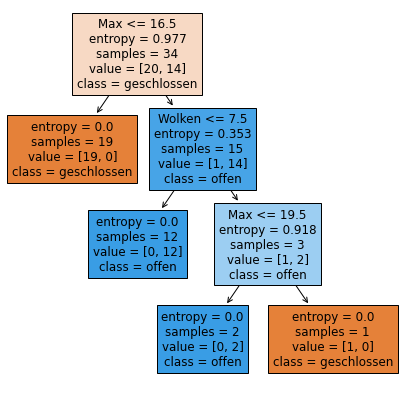

Die Verteilungen an den Knoten haben wir alle bereits gesehen; die Entropie-Werte kennen wir aber noch nicht, da wir immer die Gesamt-Entropie der beiden Unterbäume berechnet haben. 

Für den obersten Knoten haben wir zum Beispiel die Gesamt-Entropie der Knoten darunter berechnet, diese war für die von uns gewählte Aufteilung gerundet 0.156 (schauen Sie sich die Ausgabe im obigen Abschnitt [Alle Schwellwerte systematisch ausprobieren](#scrollTo=Alle_Schwellwerte_systematisch_durchprobieren) an). 

Hier nun sehen wir am obersten Knoten aber den Wert 0.977. Das ist die Entropie für die Verteilung, wenn man die Daten eben **nicht** weiter aufteilt, wenn man also am selben Knoten 20 Fälle von 'geschlossen' und 14 Fälle von 'offen' hat. Wir können das überprüfen:

In [ ]:
entropy([20,14],base=2)

Und wir finden die Gesamt-Entropie für die beiden darunter liegenden Knoten daher, wenn wir die beiden an den Unterknoten angegebenen Entropien mit den relativen Häufigkeiten gewichten: Am linken Knoten landen 19 von 34 Datenpunkten, am rechten 15 von 34. Multiplizieren wir diese mit den angegebenen Entropien von 0 bzw. 0.353, bekommen wir:

In [ ]:
19/34*0 + 15/34*0.353

gerundet also tatsächlich 0.156. 

Wir haben also durch die Aufteilung die Entropie von 0.977 auf 0.156 verbessert.

Der Vollständigkeit halber können wir kurz alle an den Knoten angegebenen Entropien berechnen:

In [ ]:
print(entropy([20,14],base=2))
print(entropy([19,0],base=2))
print(entropy([1,14],base=2))
print(entropy([20,14],base=2))
print(entropy([0,12],base=2))
print(entropy([1,2],base=2))
print(entropy([0,2],base=2))
print(entropy([1,0],base=2))


Dies sind genau die im Baum oben angezeigten Entropien. 

## Vergleich mit dem von `sklearn` erstellten Baum

Wir erstellen jetzt den Baum noch mit `sklearn`. Wie das geht, haben wir ja bereits im Notebook [Klassifikationsbäume](https://antje-schweitzer.github.io/Jupyter_Notebooks_KI_und_Maschinelles_Lernen/D4-1.Klassifikationsbäume.ipynb) gesehen. Hier ist der Code noch einmal. 

Wenn Sie den Code ausführen, kann es sein, dass Sie einen anderen Baum bekommen als oben, da `sklearn` im Fall von gleich guten Aufteilungen eine zufällig auswählt, wie oben erklärt. Dies bedeutet aber, dass Sie die folgende Zelle mehrfach ausführen können, bis Sie irgendwann denselben Baum bekommen wie wir oben. Probieren Sie es aus!

In [ ]:
# Bibliotheken laden
# für Entscheidungsbäume
from sklearn import tree
# für deren grafische Darstellung
from matplotlib import pyplot 

X=pandas.DataFrame(daten[['Max','Wolken','Wochenende']])
y=pandas.DataFrame(daten[['Zustand']])

features = ['Max','Wolken','Wochenende']
# müssen in alphabetischer Reihenfolge sein!
klassen = ['geschlossen','offen']

baum = tree.DecisionTreeClassifier(criterion='entropy')
baum.fit(X, y)

# Baum grafisch darstellen
pyplot.figure(figsize=(7,7))
tmp = tree.plot_tree(baum,feature_names=features,class_names=klassen,filled=True)


# Zusammenfassung Progammieren

* Wenn eine Funktion mehrere Objekte gleichzeitig zurückgibt, kann man sie direkt mehreren Variablen zuweisen. Dabei schreibt man bei der Zuweisung die Variablen durch Komma getrennt vor das Gleichheitszeichen.

* **Schleifen** ermöglichen es beim Programmieren, eine Sequenz von Befehlen mehrmals hintereinander zu durchlaufen.

* Durch die Schreibweise `for variable in liste_von_objekten:` leitet man eine Schleife ein, bei der im ersten Durchlauf `variable` den erste Wert aus der Liste hat, im zweiten Durchlauf den zweiten, und so weiter. Die Schleife wird beendet, wenn `variable` den Wert des letzten Elements hatte. Man sagt, es wird über die Liste **iteriert**.

* Die Sequenz von Befehlen, die durchlaufen werden soll, muss dabei unbedingt eingerückt werden.

# Zusammenfassung Training Klassifikationsbäume

* Bei `sklearn` dürfen die unabhängigen Variablen, die zur Vorhersage genutzt werden sollen, nur Zahlenwerte aufweisen. Kategoriale Variablen müssen ggf. durch Dummy-Variablen ersetzt werden.
* Es wird an jedem Knoten das Feature und der Schwellwert gesucht, die die Daten in zwei Mengen mit der niedrigsten Gesamt-Entropie aufteilen - durch systematisches Durchprobieren aller in Frage kommenden Features und Schwellwerte
* Es wird immer das aktuell beste Feature mit dem besten Schwellwert verwendet, ohne Rücksicht darauf, wie der Baum später weitergebaut wird. Diese Vorgehensweise nennt sich **greedy**. 
* Im Fall von gleich guten Aufteilungen braucht man eine Strategie, welche gewählt wird. Bei `sklearn` ist die Strategie, den Zufall entscheiden zu lassen.


# Aufgabe

Wir haben uns oben beim Bauen des ersten rechten Unterbaums dafür entschieden, gemäß des Features 'Wolken' beim Schwellwert 7.5 aufzuteilen, obwohl die Aufteilung aufgrund der Höchsttemperatur 'Max' beim Schwellwert 19.5 auch eine Option gewesen wäre. 

Probieren Sie aus, wie es weiter gegangen wäre, wenn wir uns für 'Max' entschieden hätten. 

Die Daten sind immer noch in der Variable `daten_rechter_unterbaum` gespeichert, wenn Sie den Code oben schon ausgeführt haben:


In [ ]:
daten_rechter_unterbaum 

## Andere Aufteilung für rechten Unterbaum

Teilen Sie jetzt also anders auf:

In [ ]:
# Daten gemäß der besten Aufteilung weiter aufteilen:
# links alle Daten aus dem bisherigen rechten Unterbaum, die unter 21.0 Grad sind
# der neue rechte Unterbaum besteht dann aus den Daten, die über 21.0 Grad sind
daten_neuer_linker_unterbaum = 
daten_neuer_rechter_unterbaum = 

Schauen Sie sich die Daten in den beiden neuen Unterbäumen an: welche Seite muss weiter aufgeteilt werden? 

In [ ]:
daten_neuer_linker_unterbaum

In [ ]:
daten_neuer_rechter_unterbaum

### Antwort

...

## Nächste Aufteilung finden

Probieren Sie nun mithilfe des Codes aus dem Abschnitt [Ein weiterer Unterbaum](#scrollTo=Ein_weiterer_Unterbaum) systematisch aus, welche Aufteilungen als nächstes in Frage kommen. (Spoiler: Sie sollten feststellen, dass auch hier die Aufteilung nicht eindeutig ist.) 

Beachten Sie dabei, dass Sie ggf. den Code anpassen müssen, falls Sie nicht den rechten, sondern den linken Unterbaum weiterbauen möchten. 

Welche Aufteilungen sind als nächstes möglich? 

In [ ]:
# kopieren Sie hierher den Code aus dem Abschnitt oben
# passen Sie ggf. die Variable für den Unterbaum an!



### Antwort

...

## Klassen der Aufteilung ansehen

Sie sollten Aufteilungen erhalten haben, bei denen die Entropie 0 ist. Das bedeutet, dass sauber in die Klassen 'offen' und 'geschlossen' getrennt wird (sonst wäre die Entropie > 0). 

Schauen Sie sich für beide Aufteilungen an, welche Klassen Sie links und rechts bekommen.

In [ ]:
# 1. Aufteilung
# gemäß Feature und Schwellwert in daten_links und daten_rechts aufteilen


In [ ]:
# 2. Aufteilung
# gemäß Feature und Schwellwert in daten_links und daten_rechts aufteilen


## Sinnvolle Aufteilungen

Drücken Sie beide Aufteilungen in Worten aus, und zwar so: 

* Wenn Feature X <= Schwellwert ist, ist der Eisstand in Zustand Y. 
* Wenn Feature X > Schwellwert ist, ist der Eisstand in Zustand Y. 

Ersetzen Sie dabei X durch das Feature, nach dem Sie aufteilen wollen, Schwellwert durch die Zahl, bei der Sie aufteilen wollen, und Y durch die Klasse, die die an dem Blatt verbliebenen Daten hätten. 

### Antwort

...



Welche Aufteilung halten Sie für sinnvoller? Hat der Algorithmus zum Erstellen von Entscheidungsbäumen eine Chance, auf Basis der Daten, die er bekommen hat, zu beurteilen, wie sinnvoll die beiden Aufteilungen sind? 

### Antwort

...